# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

### Imports

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from nltk.corpus import stopwords
from wordcloud import WordCloud
from hyperopt import hp, fmin, tpe, Trials, space_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Dropout, Bidirectional


## Data Load

In [2]:
datapath = ".\Data\dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [7]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
10329,Dermatitis,The discomfort in my skin has made it challeng...
10330,Dermatitis,"The raw, sensitive skin from scratching has ma..."
10331,Dermatitis,"I feel like my skin is tearing apart, causing ..."
10332,Dermatitis,Engaging in physical activities has become unb...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10334 entries, 0 to 10333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     10334 non-null  object
 1   User_input  10334 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [6]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 10334 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


<Axes: title={'center': 'Dataset balancing'}, xlabel='Disease'>

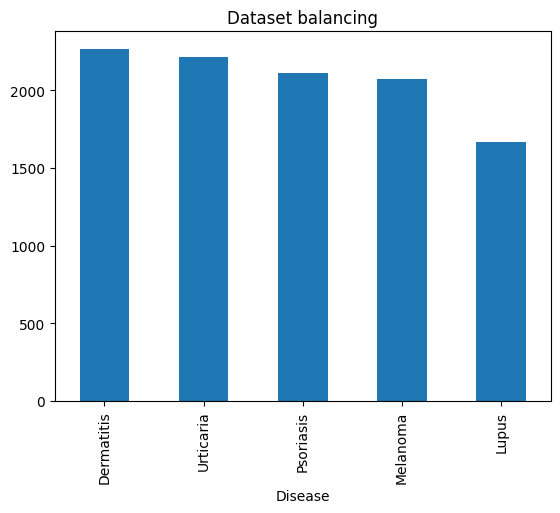

In [7]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

## Model Evaluation

In [3]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    print("\033[1mTraining Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}")

    # Test
    y_test_pred = model.predict(X_Test)
    print("\n\033[1mTesting Results\033[0m")
    print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}")
    print(f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    
    # Classification report train
    print("\n\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\n\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()


def evaluate_dp(model, history, X, Y):
    print("\n\033[1mTesting Results\033[0m")
    loss, accuracy = model.evaluate(X, Y, verbose=-1)
    print("Loss: ", loss)
    print("Accuracy: ", accuracy)

    figure_dp, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'])
    ax1.plot()

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'])
    ax2.plot()


## Text Preprocessing

In [4]:
data['User_input_preprocessed'] = data['User_input']

### Text treatment
- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [142]:
# Load english stop words using stopwords
# nltk.download('stopwords')

In [5]:
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()

In [6]:
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [8]:
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')

In [9]:
# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [10]:
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

### Stemming & Lamitization

#### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

#### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [13]:
#nltk.download('wordnet')

In [12]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_stemmed'] = data['User_input_token_whitespace'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_lemmatized'] = data['User_input_token_whitespace'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [38]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_token_whitespace,User_input_token_treebank,User_input_token_wordpunct,User_input_stemmed,User_input_lemmatized
0,Psoriasis,I have been experiencing a skin rash on my arm...,experiencing skin rash arms legs torso past we...,"[experiencing, skin, rash, arms, legs, torso, ...",experiencing skin rash arms legs torso past we...,"[experiencing, skin, rash, arms, legs, torso, ...","[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa..."
1,Psoriasis,"My skin has been peeling, especially on my kne...",skin peeling especially knees elbows scalp pee...,"[skin, peeling, especially, knees, elbows, sca...",skin peeling especially knees elbows scalp pee...,"[skin, peeling, especially, knees, elbows, sca...","[skin, peel, especi, knee, elbow, scalp, peel,...","[skin, peeling, especially, knee, elbow, scalp..."
2,Psoriasis,I have been experiencing joint pain in my fing...,experiencing joint pain fingers wrists knees p...,"[experiencing, joint, pain, fingers, wrists, k...",experiencing joint pain fingers wrists knees p...,"[experiencing, joint, pain, fingers, wrists, k...","[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne..."
3,Psoriasis,"There is a silver like dusting on my skin, esp...",silver like dusting skin especially lower back...,"[silver, like, dusting, skin, especially, lowe...",silver like dusting skin especially lower back...,"[silver, like, dusting, skin, especially, lowe...","[silver, like, dust, skin, especi, lower, back...","[silver, like, dusting, skin, especially, lowe..."
4,Psoriasis,"My nails have small dents or pits in them, and...",nails small dents pits often feel inflammatory...,"[nails, small, dents, pits, often, feel, infla...",nails small dents pits often feel inflammatory...,"[nails, small, dents, pits, often, feel, infla...","[nail, small, dent, pit, often, feel, inflamma...","[nail, small, dent, pit, often, feel, inflamma..."
...,...,...,...,...,...,...,...,...
10329,Dermatitis,The discomfort in my skin has made it challeng...,discomfort skin made challenging partake activ...,"[discomfort, skin, made, challenging, partake,...",discomfort skin made challenging partake activ...,"[discomfort, skin, made, challenging, partake,...","[discomfort, skin, made, challeng, partak, act...","[discomfort, skin, made, challenging, partake,..."
10330,Dermatitis,"The raw, sensitive skin from scratching has ma...",raw sensitive skin scratching made unbearable ...,"[raw, sensitive, skin, scratching, made, unbea...",raw sensitive skin scratching made unbearable ...,"[raw, sensitive, skin, scratching, made, unbea...","[raw, sensit, skin, scratch, made, unbear, eve...","[raw, sensitive, skin, scratching, made, unbea..."
10331,Dermatitis,"I feel like my skin is tearing apart, causing ...",feel like skin tearing apart causing excruciat...,"[feel, like, skin, tearing, apart, causing, ex...",feel like skin tearing apart causing excruciat...,"[feel, like, skin, tearing, apart, causing, ex...","[feel, like, skin, tear, apart, caus, excruci,...","[feel, like, skin, tearing, apart, causing, ex..."
10332,Dermatitis,Engaging in physical activities has become unb...,engaging physical activities become unbearable...,"[engaging, physical, activities, become, unbea...",engaging physical activities become unbearable...,"[engaging, physical, activities, become, unbea...","[engag, physic, activ, becom, unbear, due, sen...","[engaging, physical, activity, become, unbeara..."


### Tokenization

In [11]:
# Tokenization by white space
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
tokenizer = nltk.tokenize.TreebankWordDetokenizer()
data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
tokenizer = nltk.tokenize.WordPunctTokenizer()
data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [13]:
vectorizer = CountVectorizer(stop_words='english')
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
data_bow= pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out())

display(data_bow)

,abdomen,abdominal,abilities,ability,ablaze,able,abnormal,abnormalities,abnormality,abnormally,...,yearning,years,yellow,yellowish,youth,youthful,zapped,zapping,zest,zoning
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We think that to understand the symptoms is important to use n-grams

In [14]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
data_bow= pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out())

display(data_bow)

,abdomen affecting appetite,abdomen altered appetite,abdomen changed eating,abdomen constantly oozing,abdomen decreased appetite,abdomen itchy uncomfortable,abdomen making hard,abdomen making lose,abdomen relief itchiness,abdominal cramps bloating,...,yearning sense normalcy,years recently inflamed,zapped energy struggling,zapped energy vitality,zapped likely bleeding,zapped likely mole,zapping energy leaving,zapping energy making,zest life leaving,zoning work persistent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10332,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [15]:
vectorizer = TfidfVectorizer()
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
feature_names = vectorizer.get_feature_names_out()

data_tfidf = pd.DataFrame(vect.todense().tolist(), columns=feature_names)

display(data_tfidf)

,abdomen,abdominal,abilities,ability,ablaze,able,abnormal,abnormalities,abnormality,abnormally,...,years,yellow,yellowish,yet,youth,youthful,zapped,zapping,zest,zoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
#Smoothing to avoid 0 probabilities
data_tfidf = data_tfidf + 1

# Normalize
data_tfidf = data_tfidf.div(data_tfidf.sum(axis=1), axis=0)

display(data_tfidf)

,abdomen,abdominal,abilities,ability,ablaze,able,abnormal,abnormalities,abnormality,abnormally,...,years,yellow,yellowish,yet,youth,youthful,zapped,zapping,zest,zoning
0,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
1,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
2,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
3,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
4,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10329,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
10330,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
10331,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342
10332,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342


## Data Visualization

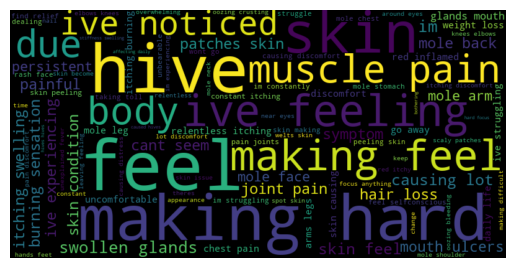

In [16]:
# General word cloud
word_list = " ".join(text for text in data['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

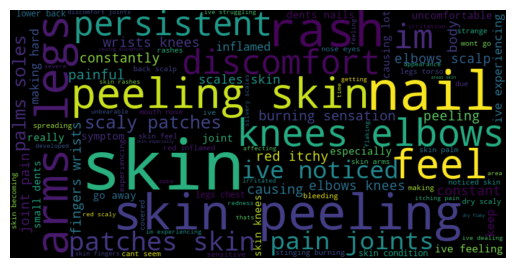

In [17]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

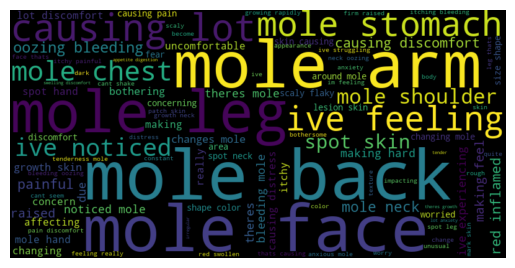

In [18]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

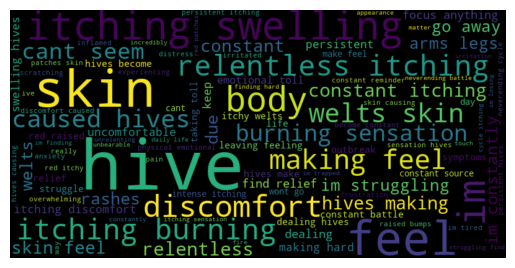

In [159]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

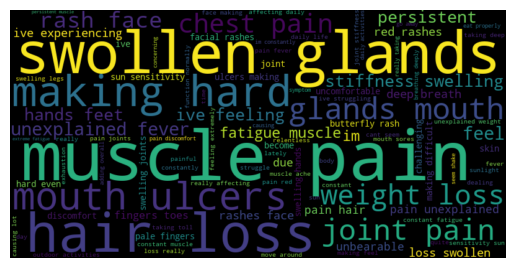

In [160]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

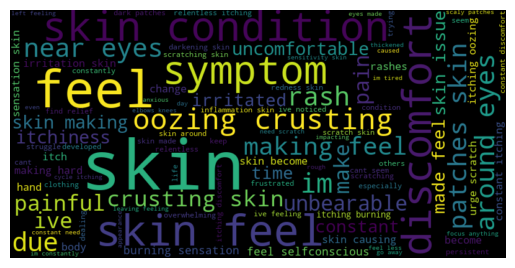

In [161]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [17]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 8267 rows and 8 columns.
Test dataset contains 2067 rows and 8 columns.


In [40]:
display(train)

,Disease,User_input,User_input_preprocessed,User_input_token_whitespace,User_input_token_treebank,User_input_token_wordpunct,User_input_stemmed,User_input_lemmatized
4880,Urticaria,I'm struggling to find moments of peace amidst...,im struggling find moments peace amidst chaos ...,"[im, struggling, find, moments, peace, amidst,...",im struggling find moments peace amidst chaos ...,"[im, struggling, find, moments, peace, amidst,...","[im, struggl, find, moment, peac, amidst, chao...","[im, struggling, find, moment, peace, amidst, ..."
6651,Lupus,My sensitivity to sunlight is causing me a lot...,sensitivity sunlight causing lot discomfort ma...,"[sensitivity, sunlight, causing, lot, discomfo...",sensitivity sunlight causing lot discomfort ma...,"[sensitivity, sunlight, causing, lot, discomfo...","[sensit, sunlight, caus, lot, discomfort, make...","[sensitivity, sunlight, causing, lot, discomfo..."
6451,Urticaria,The hives have disrupted every aspect of my li...,hives disrupted every aspect life work social ...,"[hives, disrupted, every, aspect, life, work, ...",hives disrupted every aspect life work social ...,"[hives, disrupted, every, aspect, life, work, ...","[hive, disrupt, everi, aspect, life, work, soc...","[hive, disrupted, every, aspect, life, work, s..."
4157,Melanoma,I've recently noticed this growth on my leg th...,ive recently noticed growth leg causing lot tr...,"[ive, recently, noticed, growth, leg, causing,...",ive recently noticed growth leg causing lot tr...,"[ive, recently, noticed, growth, leg, causing,...","[ive, recent, notic, growth, leg, caus, lot, t...","[ive, recently, noticed, growth, leg, causing,..."
828,Psoriasis,I struggle with painful swelling in my joints ...,struggle painful swelling joints daily,"[struggle, painful, swelling, joints, daily]",struggle painful swelling joints daily,"[struggle, painful, swelling, joints, daily]","[struggl, pain, swell, joint, daili]","[struggle, painful, swelling, joint, daily]"
...,...,...,...,...,...,...,...,...
5734,Urticaria,The hives on my skin have caused such intense ...,hives skin caused intense itching swelling lea...,"[hives, skin, caused, intense, itching, swelli...",hives skin caused intense itching swelling lea...,"[hives, skin, caused, intense, itching, swelli...","[hive, skin, caus, intens, itch, swell, leav, ...","[hive, skin, caused, intense, itching, swellin..."
5191,Urticaria,The itching and swelling have become a constan...,itching swelling become constant source stress...,"[itching, swelling, become, constant, source, ...",itching swelling become constant source stress...,"[itching, swelling, become, constant, source, ...","[itch, swell, becom, constant, sourc, stress, ...","[itching, swelling, become, constant, source, ..."
5390,Urticaria,It feels like I'm living in a body that's been...,feels like im living body thats hijacked relen...,"[feels, like, im, living, body, thats, hijacke...",feels like im living body thats hijacked relen...,"[feels, like, im, living, body, thats, hijacke...","[feel, like, im, live, bodi, that, hijack, rel...","[feel, like, im, living, body, thats, hijacked..."
860,Psoriasis,I'm frustrated by the visible scales that have...,im frustrated visible scales formed body,"[im, frustrated, visible, scales, formed, body]",im frustrated visible scales formed body,"[im, frustrated, visible, scales, formed, body]","[im, frustrat, visibl, scale, form, bodi]","[im, frustrated, visible, scale, formed, body]"


In [18]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['User_input_lemmatized'].apply(' '.join))

TfidfVectorizer()

In [19]:
#Create X and y train and test
X_train = vectorizer.transform(train['User_input_lemmatized'].apply(' '.join))
y_train = train['Disease']

X_test = vectorizer.transform(test['User_input_lemmatized'].apply(' '.join))
y_test = test['Disease']

In [43]:
display(X_train)

<8267x2703 sparse matrix of type '<class 'numpy.float64'>'
	with 68156 stored elements in Compressed Sparse Row format>

## Text classification

### Machine Learning

#### Logistic Regression

**Important Parameters:**
- Solver
- Penalty
- C
- Max_Iter

##### Hyperopt

In [ ]:
space = {
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']),
    'penalty': hp.choice('penalty', ['l2']),
    'C': hp.uniform('C', 1.0, 10.0),
    'max_iter': hp.choice('max_iter', [1, 2, 5, 10, 20, 50, 100, 200, 500])
}

def objective(params):
    clf = LogisticRegression(solver=params['solver'], penalty=params['penalty'], C=params['C'], max_iter=params['max_iter'])
    score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
    return -score

tpe_algorithm = tpe.suggest

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,  
            trials=trials)

best_params = space_eval(space, best)
print("Best hyperparameters:", best_params)

##### Grid Search

In [165]:
#Grid Search
lr = LogisticRegression()

param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1','l2'],
        'C': np.arange(1.0, 10.0, 1.0),
        'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
    },
    {
        'solver': ['lbfgs','newton-cg','sag'],
        'penalty': ['l2',],
        'C': np.arange(1.0, 10.0, 1.0),
        'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
    },
    {
        'solver': ['saga', 'sag', 'newton-cg', 'lbfgs'],
        'penalty': [None],
        'max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500]
    }
]

grid = GridSearchCV(estimator=lr, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
grid.fit(X_train.toarray(), y_train)

print(f"Best parameters: {grid.best_params_}")

Best parameters: {'C': 5.0, 'max_iter': 10, 'penalty': 'l2', 'solver': 'liblinear'}


c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c:\Users\mafs6\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training Data Results
Accuracy Score: 0.9447
Specificity Score: 0.9447
Precision Score: 0.9452
F1 Score: 0.9448

Testing Data Results
Accuracy Score: 0.8747
Specificity Score: 0.8747
Precision Score: 0.8766
F1 Score: 0.8752

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.88      0.92      0.90      1803
       Lupus       0.98      0.99      0.98      1355
    Melanoma       0.99      0.99      0.99      1677
   Psoriasis       0.93      0.89      0.91      1668
   Urticaria       0.96      0.94      0.95      1764

    accuracy                           0.94      8267
   macro avg       0.95      0.95      0.95      8267
weighted avg       0.95      0.94      0.94      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.78      0.85      0.82       463
       Lupus       0.95      0.92      0.93       314
    Melanoma       0.97      0.97      0.97       393
   Psoriasis 

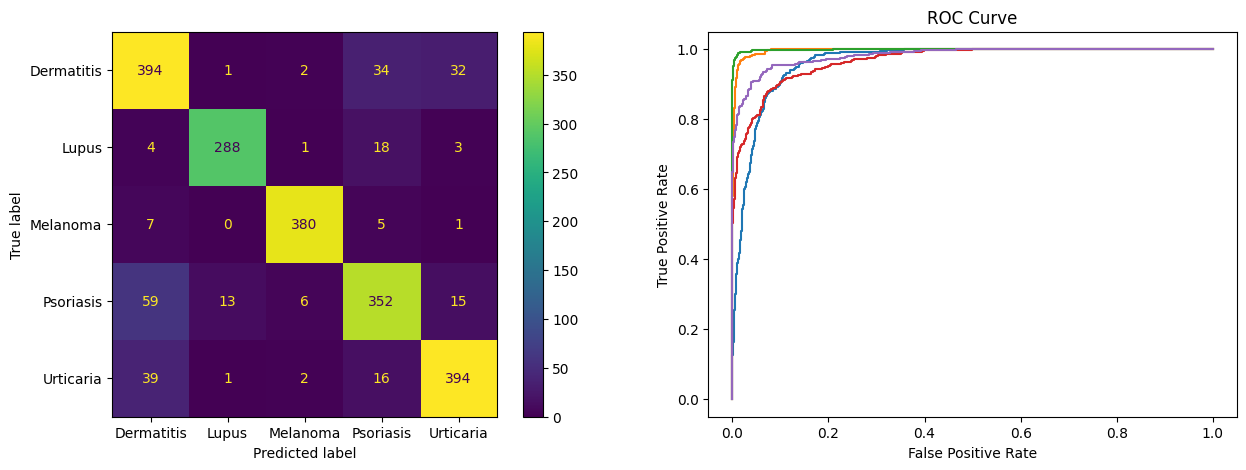

In [33]:
# Train logistic regression
lr = LogisticRegression(C=4.017085497225305, solver='sag', max_iter=10, penalty='l2')
model = lr.fit(X_train, y_train)

evaluate(model, X_train, X_test, y_train, y_test)

#### Naive Bayes

**Important Parameters:**
- Var Smoothing

##### Hyperopt ####

In [25]:
space = {
    'var_smoothing': hp.choice('var_smoothing', np.logspace(0, -9, num=100))
}

def objective(params):
    clf = GaussianNB(var_smoothing=params['var_smoothing'])
    score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
    return -score

tpe_algorithm = tpe.suggest

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

best_params = space_eval(space, best)
print("Best hyperparameters:", best_params)

100%|██████████| 50/50 [01:26<00:00,  1.73s/trial, best loss: -0.755535170745945]
Best hyperparameters: {'var_smoothing': 0.0533669923120631}


##### Grid Search

In [166]:
nb = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

gs_nb = GridSearchCV(estimator=nb, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
gs_nb.fit(X_train.toarray(), y_train)

print(f"Best parameters: {gs_nb.best_params_}")

Best parameters: {'var_smoothing': 0.1}


##### Function Naive Bayes #####


Training Data Results
Accuracy Score: 0.8375
Specificity Score: 0.8375
Precision Score: 0.8409
F1 Score: 0.8322

Testing Data Results
Accuracy Score: 0.7596
Specificity Score: 0.7596
Precision Score: 0.7577
F1 Score: 0.7517

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.87      0.63      0.73      1803
       Lupus       0.84      0.98      0.90      1355
    Melanoma       0.83      0.99      0.90      1677
   Psoriasis       0.86      0.77      0.82      1668
   Urticaria       0.80      0.86      0.83      1764

    accuracy                           0.84      8267
   macro avg       0.84      0.85      0.84      8267
weighted avg       0.84      0.84      0.83      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.73      0.53      0.62       463
       Lupus       0.78      0.93      0.85       314
    Melanoma       0.77      0.95      0.86       393
   Psoriasis 

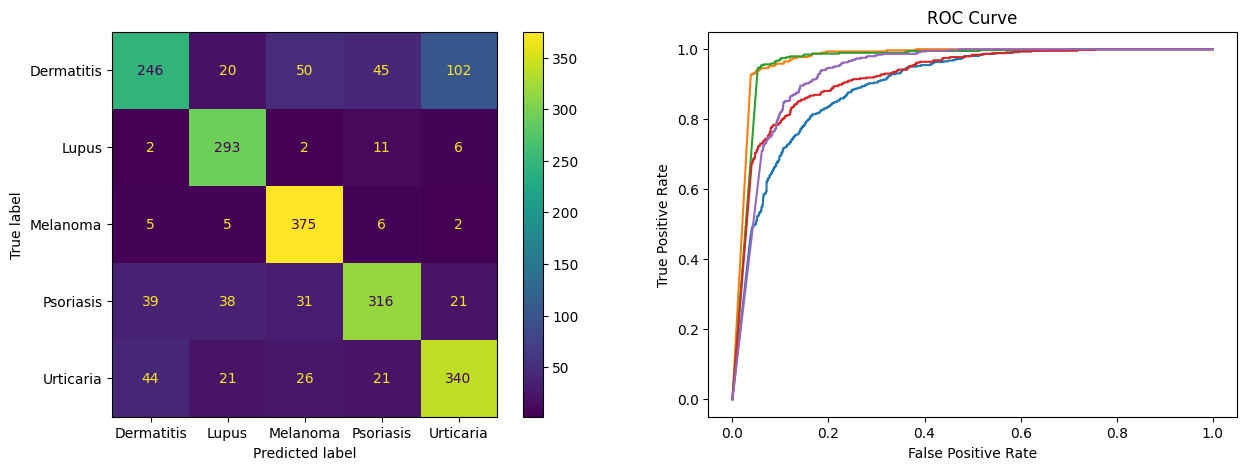

In [26]:
naive_bayes = GaussianNB(var_smoothing=0.0533669923120631)
model = naive_bayes.fit(X_train.toarray(), y_train)

evaluate(model, X_train.toarray(), X_test.toarray(), y_train, y_test)

#### Support Vector Machinne

**Important Parameters:**
- Kernel
- Gamma
- C

##### Hyperopt #####

In [19]:
space = {
    'C': hp.choice('C', [0.1, 1, 10, 100, 1000]),
    'gamma': hp.choice('gamma', [1, 0.1, 0.01, 0.001, 0.0001]),
    'kernel': hp.choice('kernel', ['rbf', 'linear'])
}

def objective(params):
    clf = SVC(C=1, gamma=params['gamma'], kernel=params['kernel'])
    score = cross_val_score(clf, X_train.toarray(), y_train, cv=5).mean()
    return -score 

tpe_algorithm = tpe.suggest

trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,
            trials=trials)

best_params = space_eval(space, best)
print("Best hyperparameters:", best_params)

100%|██████████| 50/50 [2:54:32<00:00, 209.45s/trial, best loss: -0.8808512755014334]  
Best hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


##### Grid Search

In [2]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

gs_svm = GridSearchCV(estimator=svm, param_grid=param_grid, verbose=0, n_jobs=-1, cv=2, scoring='accuracy')
gs_svm.fit(X_train.toarray(), y_train)

print(f"Best parameters: {gs_svm.best_params_}")


NameError: name 'SVC' is not defined

##### Function Support Vector Machine ####


Training Data Results
Accuracy Score: 0.8409
Specificity Score: 0.8409
Precision Score: 0.8825
F1 Score: 0.8473

Testing Data Results
Accuracy Score: 0.8031
Specificity Score: 0.8031
Precision Score: 0.8529
F1 Score: 0.8102

Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       0.61      0.95      0.74      1803
       Lupus       0.97      0.85      0.90      1355
    Melanoma       1.00      0.93      0.96      1677
   Psoriasis       0.91      0.67      0.77      1668
   Urticaria       0.96      0.80      0.87      1764

    accuracy                           0.84      8267
   macro avg       0.89      0.84      0.85      8267
weighted avg       0.88      0.84      0.85      8267


Classification Report Test
              precision    recall  f1-score   support

  Dermatitis       0.57      0.94      0.71       463
       Lupus       0.94      0.76      0.84       314
    Melanoma       0.99      0.92      0.95       393
   Psoriasis 

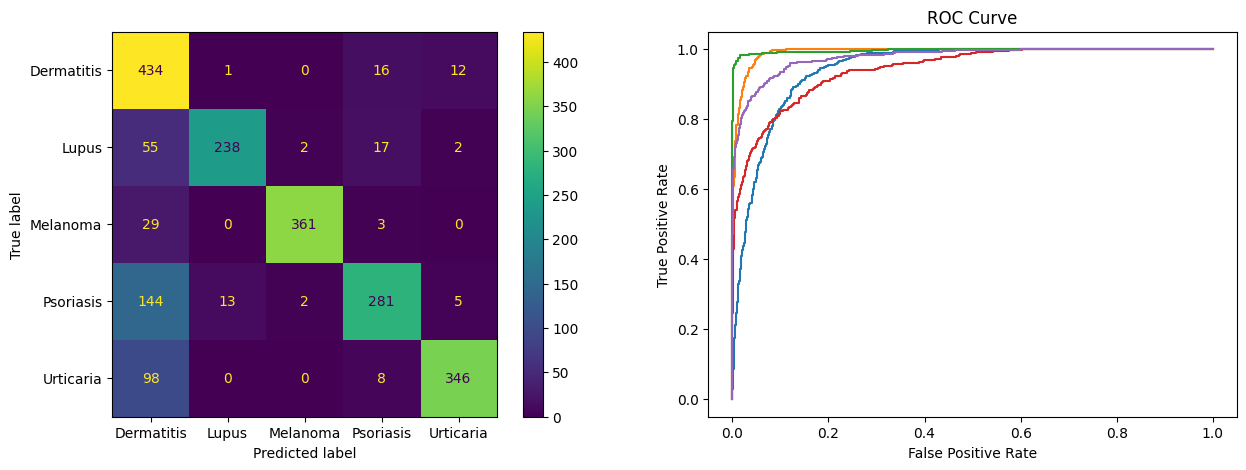

In [21]:
svm = SVC(C=0.1, gamma=1,kernel='rbf', probability=True)
model = svm.fit(X_train, y_train)

evaluate(model, X_train, X_test, y_train, y_test)

### Deep Learning

#### Recurrent Neural Network

In [29]:
# Create RNN model for text classification
vocab_size = 5000
embedding_dim = 32

rnn = Sequential(name="Basic_RNN")
rnn.add(Embedding(vocab_size, embedding_dim))
rnn.add(SimpleRNN(128, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(64, activation='relu', return_sequences= True))
rnn.add(SimpleRNN(32, activation='relu'))
rnn.add(Dense(4, activation='softmax'))

rnn.build(input_shape=(None, X_train.shape[1]))

print(rnn.summary())

rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = rnn.fit(X_train.toarray(), y_train, epochs=10, validation_data=(X_test.toarray(), y_test))

Model: "Basic_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 2703, 128)      │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_25 (SimpleRNN)       │ (None, 2703, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_26 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,196 (766.39 KB)

 Trainable params: 196,196 (766.39 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Conv 1D

In [31]:
# Create Conv1D model for text classification
conv1d = Sequential(name="Conv1D")
conv1d.add(Embedding(vocab_size, embedding_dim))
conv1d.add(Conv1D(128, 5, activation='relu'))
conv1d.add(GlobalMaxPooling1D())
conv1d.add(Dense(64, activation='relu'))
conv1d.add(Dense(4, activation='softmax'))

conv1d.build(input_shape=(None, X_train.shape[1]))

print(conv1d.summary())

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2699, 128)      │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,124 (738.77 KB)

 Trainable params: 189,124 (738.77 KB)

 Non-trainable params: 0 (0.00 B)

None


#### LSTM

In [36]:
# Create LSTM model for text classification
lstm = Sequential(name="LSTM")
lstm.add(Embedding(vocab_size, embedding_dim))
lstm.add(LSTM(32))
lstm.add(Dropout(0.4))
lstm.add(Dense(4, activation='softmax'))

lstm.build(input_shape=(None, X_train.shape[1]))

print(lstm.summary())

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,452 (658.02 KB)

 Trainable params: 168,452 (658.02 KB)

 Non-trainable params: 0 (0.00 B)

None


#### BILSTM

In [41]:
# Create LSTM model for text classification
blstm = Sequential(name="Bi_LSTM")
blstm.add(Embedding(vocab_size, embedding_dim))
blstm.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
blstm.add(Dropout(0.4))
blstm.add(Bidirectional(LSTM(32)))
blstm.add(Dropout(0.2))
blstm.add(Dense(64, activation='relu'))
blstm.add(Dropout(0.1))
blstm.add(Dense(4, activation='softmax'))

blstm.build(input_shape=(None, X_train.shape[1]))

print(blstm.summary())


c:\Users\Maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Bi_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 2703, 32)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 2703, 128)      │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2703, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 255,300 (997.27 KB)

 Trainable params: 255,300 (997.27 KB)

 Non-trainable params: 0 (0.00 B)

None
